In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
plt.style.use('seaborn')



def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf.flatten(),index=eVal.flatten())
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec

def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

"""
 FITTING
 THE
 MARCENKO–PASTUR PDF
"""
from scipy.optimize import minimize
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x: errPDFs(*x), .5 , args=(eVal,q,bWidth),
                    bounds=((1E-5,1-1E-5),)
                )
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax, var

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

### Import new CC data

In [74]:
result = pd.read_csv('~/Works/practicum_github_repo/Crypto-Data/ml_finance/data/consolidated_coin_data.csv')

/home/harshal/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [50]:
result

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,0x,"Feb 11, 2018",1.09,1.09,0.934155,0.979054,4888770,555363000
1,0x,"Feb 10, 2018",1.14,1.2,0.985705,1.1,10828700,576535000
2,0x,"Feb 09, 2018",1.08,1.15,1.01,1.14,5979420,545842000
3,0x,"Feb 08, 2018",0.988963,1.13,0.988963,1.07,12992800,501142000
4,0x,"Feb 07, 2018",1.01,1.16,0.902145,0.993355,13476600,513163000
...,...,...,...,...,...,...,...,...
83151,zilliqa,"Jan 29, 2018",0.097167,0.099824,0.077958,0.089273,12441600,-
83152,zilliqa,"Jan 28, 2018",0.101224,0.112499,0.095968,0.097296,20910700,-
83153,zilliqa,"Jan 27, 2018",0.118157,0.120932,0.091614,0.100976,7967360,-
83154,zilliqa,"Jan 26, 2018",0.135555,0.159557,0.091337,0.119375,13714100,-


In [90]:
result['Date'] = pd.to_datetime(result['Date'], format='%b %d, %Y', errors='coerce')
result = result.dropna()
result = result[['Currency', 'Date', 'Close']]
result = result.pivot(index='Date', values='Close', columns='Currency')
result = result.rename_axis(None, axis=1).reset_index()
result.Date.max() #.set_index('Date')
result = result.set_index('Date')
result = result[(result.index >= '2017-01-01') & ((result.index <= '2017-12-31'))]
# result = result[(result.index >= '2019-01-01')]
result = result.astype(float)

In [91]:
result

,0x,achain,adx-net,aelf,aeternity,agoras-tokens,aion,airswap,amber,appcoins,...,waves,wax,wings,xplay,xtrabytes,zcash,zclassic,zcoin,zencash,zilliqa
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,0.128713,NaN,NaN,NaN,NaN,...,0.221322,NaN,NaN,NaN,NaN,48.47,0.392851,0.482722,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,0.129767,NaN,NaN,NaN,NaN,...,0.232679,NaN,NaN,NaN,NaN,49.79,0.409965,0.482545,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,0.125279,NaN,NaN,NaN,NaN,...,0.239930,NaN,NaN,NaN,NaN,50.04,0.407882,0.599075,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,0.120499,NaN,NaN,NaN,NaN,...,0.241312,NaN,NaN,NaN,NaN,57.03,0.421588,0.606988,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,0.108419,NaN,NaN,NaN,NaN,...,0.233087,NaN,NaN,NaN,NaN,49.84,0.372201,0.492633,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,0.669701,0.369398,3.06,1.090000,1.49,3.430000,5.43,0.410422,0.626833,NaN,...,13.580000,0.833783,1.29,0.084035,0.231960,554.07,42.660000,126.250000,44.09,NaN
2017-12-28,0.646711,0.333399,2.75,0.968674,1.32,2.970000,4.83,0.378436,0.557877,NaN,...,12.710000,0.777109,1.17,0.101728,0.223995,507.26,51.870000,116.290000,42.78,NaN
2017-12-29,0.684076,0.406930,2.70,1.010000,1.33,2.930000,4.75,0.413307,0.538755,NaN,...,13.640000,1.030000,1.23,0.107936,0.369515,571.90,85.180000,120.000000,45.92,NaN


In [120]:
result = result.loc[:, ~result.columns.isin(['tether'])]

In [121]:
returns = result.pct_change().iloc[1:, :].copy()
returns.dropna(axis = 1, thresh=len(returns.index)/2, inplace=True) # Drop stocks with over half the data missing
returns.dropna(axis = 0, thresh=len(returns.columns), inplace=True) # Drop days without data for all stocks

In [122]:
list(returns.index.unique())

[Timestamp('2017-07-03 00:00:00'),
 Timestamp('2017-07-04 00:00:00'),
 Timestamp('2017-07-05 00:00:00'),
 Timestamp('2017-07-06 00:00:00'),
 Timestamp('2017-07-07 00:00:00'),
 Timestamp('2017-07-08 00:00:00'),
 Timestamp('2017-07-09 00:00:00'),
 Timestamp('2017-07-10 00:00:00'),
 Timestamp('2017-07-11 00:00:00'),
 Timestamp('2017-07-12 00:00:00'),
 Timestamp('2017-07-13 00:00:00'),
 Timestamp('2017-07-14 00:00:00'),
 Timestamp('2017-07-15 00:00:00'),
 Timestamp('2017-07-16 00:00:00'),
 Timestamp('2017-07-17 00:00:00'),
 Timestamp('2017-07-18 00:00:00'),
 Timestamp('2017-07-19 00:00:00'),
 Timestamp('2017-07-20 00:00:00'),
 Timestamp('2017-07-21 00:00:00'),
 Timestamp('2017-07-22 00:00:00'),
 Timestamp('2017-07-23 00:00:00'),
 Timestamp('2017-07-24 00:00:00'),
 Timestamp('2017-07-25 00:00:00'),
 Timestamp('2017-07-26 00:00:00'),
 Timestamp('2017-07-27 00:00:00'),
 Timestamp('2017-07-28 00:00:00'),
 Timestamp('2017-07-29 00:00:00'),
 Timestamp('2017-07-30 00:00:00'),
 Timestamp('2017-07-

In [123]:
returns

,adx-net,aeternity,agoras-tokens,aragon,ardor,ark,asch,augur,bancor,basic-attention-token,...,veritaseum,vertcoin,viacoin,waves,wings,xtrabytes,zcash,zclassic,zcoin,zencash
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-03,0.068528,0.129133,-0.166029,-0.024691,-0.007506,-0.035749,0.101791,0.096836,-0.010274,0.037370,...,-0.049153,-0.011390,0.038760,0.052486,0.102955,0.242479,-0.034186,0.097143,-0.004244,-0.006173
2017-07-04,0.741353,-0.285898,-0.017155,-0.067511,0.002265,0.143518,0.703757,-0.042405,-0.013841,0.019861,...,1.199508,0.059263,-0.037313,0.133858,-0.009218,-0.129455,-0.032069,0.015625,0.019608,0.155280
2017-07-05,-0.329648,0.159980,-0.118075,0.049774,-0.046513,0.253813,-0.169292,-0.024319,-0.021053,-0.017890,...,0.091452,-0.027927,-0.069767,0.055556,0.014705,0.058701,0.002835,-0.051282,-0.024247,-0.014337
2017-07-06,0.073647,-0.136219,-0.114261,0.056034,-0.097976,-0.058911,-0.338034,0.023065,-0.003584,-0.059959,...,0.013721,-0.130101,-0.041667,-0.048246,-0.040520,-0.204418,0.016961,-0.032432,-0.018852,-0.069091
2017-07-07,-0.329849,-0.237451,-0.016631,-0.146939,-0.196931,-0.148280,-0.141895,-0.161455,-0.104317,-0.111332,...,-0.187660,-0.224405,-0.113043,-0.131336,-0.021170,-0.065735,-0.135784,-0.089385,-0.142358,-0.023438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,0.003279,0.034722,0.005865,0.021333,-0.018293,-0.056051,-0.021277,-0.065770,0.002020,0.003917,...,-0.063728,-0.028909,0.043880,-0.043662,-0.085106,-0.039861,-0.034688,1.886333,-0.113600,0.044539
2017-12-28,-0.101307,-0.114094,-0.134111,-0.039164,0.055901,-0.075574,-0.101449,-0.078222,0.020161,-0.060874,...,-0.064685,-0.054127,-0.008850,-0.064065,-0.093023,-0.034338,-0.084484,0.215893,-0.078891,-0.029712
2017-12-29,-0.018182,0.007576,-0.013468,0.073370,0.000000,0.150365,0.024194,0.030711,0.071146,-0.000126,...,0.153197,0.025751,0.011161,0.073171,0.051282,0.649657,0.127430,0.642182,0.031903,0.073399


In [147]:
training_period = 30
in_sample = returns.iloc[:(returns.shape[0]-training_period), :].copy()

In [148]:
tickers = returns.columns

In [149]:
pd.set_option('use_inf_as_na', True)
in_sample_log_returns = np.log(1+in_sample)
# log_returns.dropna(0, inplace= True)
# log_returns.dropna(1, inplace= True)

In [150]:
# We will need the standard deviations later:
variances = np.diag(in_sample_log_returns.cov().values)
standard_deviations = np.sqrt(variances) 

In [151]:
corr_mat = in_sample_log_returns.interpolate().corr()

In [152]:
"""
Start with CCs correlation matrix 
"""
eVal0,eVec0=getPCA(corr_mat)

In [153]:
q = returns.shape[0]/corr_mat.shape[0]

In [154]:
# get bulk of Evalue and Variance
eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
# get nFacts
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

In [155]:
nFacts0

1

In [156]:
var0

0.99999

In [157]:
eMax0

2.914184420237471

In [158]:
D, S = np.linalg.eigh(corr_mat)

print(D[D > eMax0])

[36.25770883]


In [159]:
len(D)

91

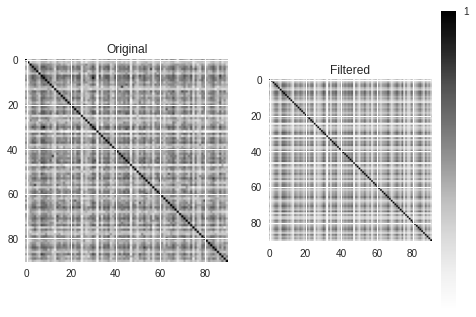

In [160]:
# Filter the eigenvalues out
D[D <= eMax0] = 0

# Reconstruct the matrix
temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))

# Set the diagonal entries to 0
np.fill_diagonal(temp, 1)
filtered_matrix = temp

f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(filtered_matrix)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [161]:
nFacts0

1

In [162]:
"""
 SNIPPET 2.5 DENOISING
 BY
 CONSTANT RESIDUAL EIGENVALUE
"""
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

# get denoised correlation matrix
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [163]:
eVal2,eVec2=getPCA(filtered_matrix)

In [164]:
findMaxEval(np.diag(eVec1), q, bWidth=.01)

(2.914184420237471, 0.99999)

In [165]:
findMaxEval(np.diag(eVec2), q, bWidth=.01)

(2.914184420237471, 0.99999)

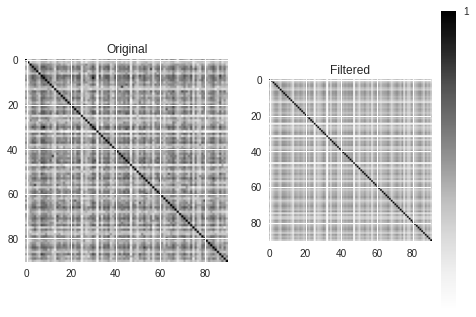

In [166]:
f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(corr1)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [167]:
in_sample

,adx-net,aeternity,agoras-tokens,aragon,ardor,ark,asch,augur,bancor,basic-attention-token,...,veritaseum,vertcoin,viacoin,waves,wings,xtrabytes,zcash,zclassic,zcoin,zencash
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-03,0.068528,0.129133,-0.166029,-0.024691,-0.007506,-0.035749,0.101791,0.096836,-0.010274,0.037370,...,-0.049153,-0.011390,0.038760,0.052486,0.102955,0.242479,-0.034186,0.097143,-0.004244,-0.006173
2017-07-04,0.741353,-0.285898,-0.017155,-0.067511,0.002265,0.143518,0.703757,-0.042405,-0.013841,0.019861,...,1.199508,0.059263,-0.037313,0.133858,-0.009218,-0.129455,-0.032069,0.015625,0.019608,0.155280
2017-07-05,-0.329648,0.159980,-0.118075,0.049774,-0.046513,0.253813,-0.169292,-0.024319,-0.021053,-0.017890,...,0.091452,-0.027927,-0.069767,0.055556,0.014705,0.058701,0.002835,-0.051282,-0.024247,-0.014337
2017-07-06,0.073647,-0.136219,-0.114261,0.056034,-0.097976,-0.058911,-0.338034,0.023065,-0.003584,-0.059959,...,0.013721,-0.130101,-0.041667,-0.048246,-0.040520,-0.204418,0.016961,-0.032432,-0.018852,-0.069091
2017-07-07,-0.329849,-0.237451,-0.016631,-0.146939,-0.196931,-0.148280,-0.141895,-0.161455,-0.104317,-0.111332,...,-0.187660,-0.224405,-0.113043,-0.131336,-0.021170,-0.065735,-0.135784,-0.089385,-0.142358,-0.023438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,0.050000,-0.018715,0.126654,0.167488,0.044460,0.082621,-0.020777,0.057699,0.003745,0.040935,...,0.124863,-0.018282,0.059172,-0.005282,0.037322,0.004332,0.021668,0.025126,0.066704,0.036543
2017-11-28,0.023810,-0.021915,-0.153690,-0.063291,0.052973,-0.092105,0.073578,-0.007644,-0.029851,0.047363,...,-0.005438,-0.052142,0.055866,0.049558,0.001563,-0.003882,0.068286,0.014706,0.125591,-0.027284
2017-11-29,-0.217054,-0.034377,-0.110838,-0.189189,-0.175487,-0.165217,-0.151489,-0.149860,-0.096154,-0.225266,...,-0.112587,-0.031434,-0.153439,-0.128162,-0.154303,-0.013952,-0.175547,-0.082126,-0.108543,-0.119130


## Including Tether Throws off the Portfolio Even for 2017

          Investment Weight
tether             0.916929
bitcoin            0.017692
ripple             0.008621
ethereum           0.008207
dash               0.008057


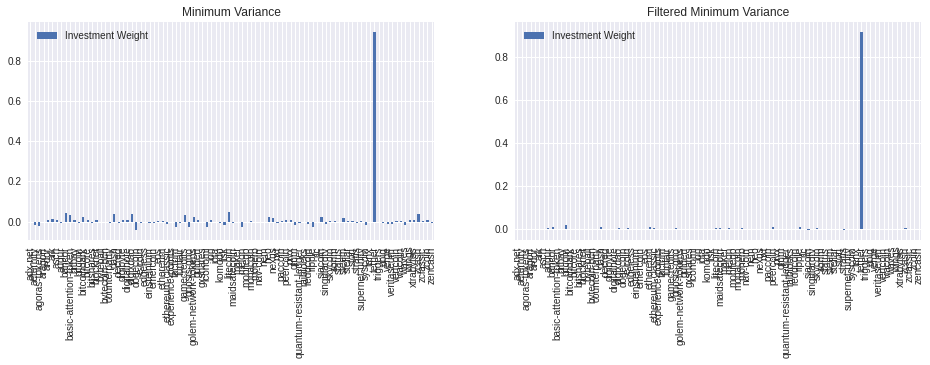

In [119]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(16,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

## After taking out tether portfolio much more reasonable here

          Investment Weight
bitcoin            0.357332
ripple             0.172240
dash               0.154596
ethereum           0.140592
peercoin           0.129437


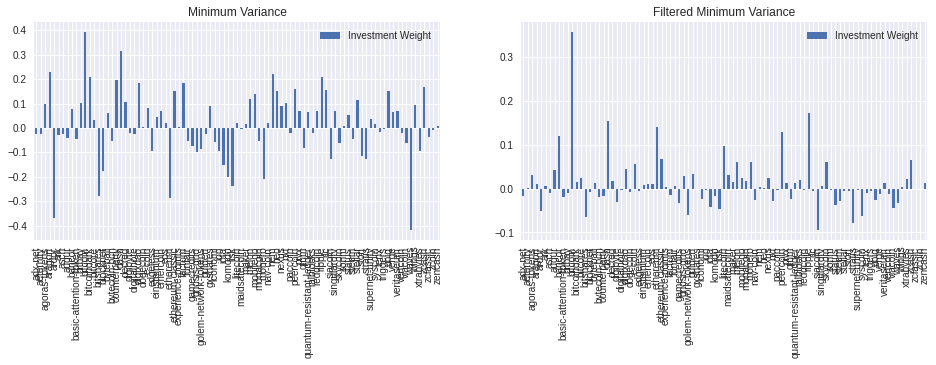

In [145]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(16,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

## Interesting as the MVR portfolio doesn't offer much better returns here, possibly because of 2017 inflation?

Text(0.5, 1.0, 'Filtered (Blue) vs. Normal (Black)')

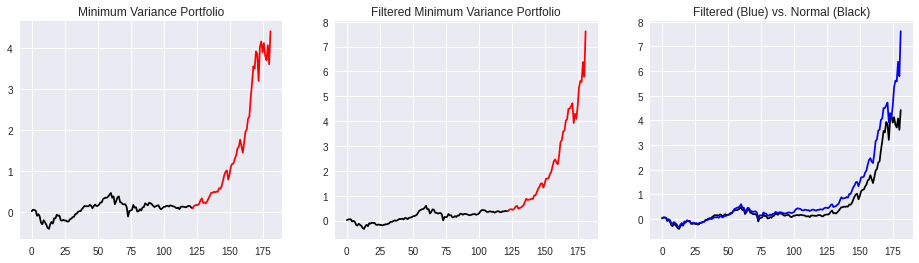

In [146]:
def get_cumulative_returns_over_time(sample, weights):
    # Ignoring short sales
    weights[weights <= 0 ] = 0 
    weights = weights / weights.sum()
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values

f = plt.figure(figsize=(16,4))

ax = plt.subplot(131)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(132)
ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
plt.title("Filtered Minimum Variance Portfolio")

ax = plt.subplot(133)
ax.plot(cumulative_returns, 'black')
ax.plot(cumulative_returns_filt, 'b')
plt.title("Filtered (Blue) vs. Normal (Black)")

### Set test period as 30 days, which is dec of 2017

          Investment Weight
bitcoin            0.373385
ripple             0.181924
ethereum           0.180256
bancor             0.150171
litecoin           0.112570


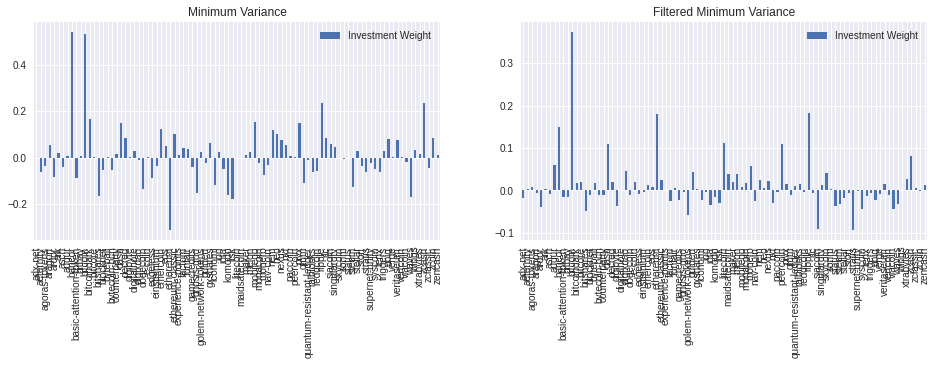

In [168]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(16,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

## Almost similar returns for 30 days as 60 days test 

Text(0.5, 1.0, 'Filtered (Blue) vs. Normal (Black)')

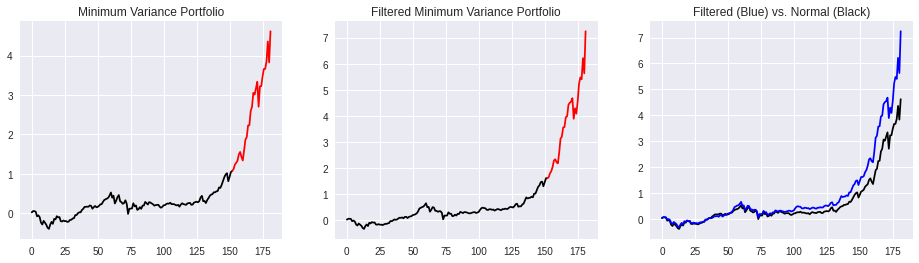

In [169]:
def get_cumulative_returns_over_time(sample, weights):
    # Ignoring short sales
    weights[weights <= 0 ] = 0 
    weights = weights / weights.sum()
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values

f = plt.figure(figsize=(16,4))

ax = plt.subplot(131)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(132)
ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
plt.title("Filtered Minimum Variance Portfolio")

ax = plt.subplot(133)
ax.plot(cumulative_returns, 'black')
ax.plot(cumulative_returns_filt, 'b')
plt.title("Filtered (Blue) vs. Normal (Black)")

## Misc attempts

          Investment Weight
btcusd             0.295364
zecusd             0.155198
miotausd           0.140110
qtumusd            0.140104
mgousd             0.125378


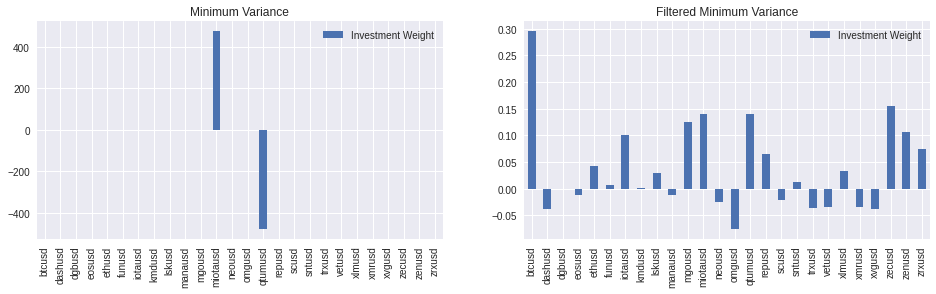

In [337]:
# Reconstruct the filtered covariance matrix
covariance_matrix = returns.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(16,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(corr1,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

In [338]:
filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False)

,Investment Weight
btcusd,0.295364
zecusd,0.155198
miotausd,0.140110
qtumusd,0.140104
mgousd,0.125378
zenusd,0.105607
iotausd,0.100883
zrxusd,0.074942
repusd,0.065050
ethusd,0.041671
